In [47]:
file1 = "../remote/CRANK_NICOLSON_64_Silicon_etch.off"
# file2 = "../remote/Silicon_etch.off"
# file1 = "../remote/Nitride_etch.obj"
file2 = "../initial_struct_600_600.off"

In [48]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.distance import directed_hausdorff
from scipy import interpolate

def load_mesh(file_path):
    """Load a mesh from file path"""
    mesh = trimesh.load(file_path, force='mesh')
    if not isinstance(mesh, trimesh.Trimesh):
        raise TypeError("Loaded file is not a valid mesh.")
    return mesh

def slice_mesh(mesh, y_level):
    """Slice mesh at specified Y level"""
    plane_origin = np.array([0.0, y_level, 0.0])
    plane_normal = np.array([0.0, 1.0, 0.0])
    slice_section = mesh.section(plane_origin=plane_origin, plane_normal=plane_normal)
    
    if slice_section is None:
        print(f"No intersection at y = {y_level}")
        return None
    
    slice_2D, to_3D = slice_section.to_planar()
    return slice_2D

def extract_contour_points(slice_2D, num_points=100):
    """Extract and normalize contour points"""
    if slice_2D is None:
        return None
    
    contours = slice_2D.discrete
    if not contours:
        return None
    
    # Get the longest contour (main shape)
    longest_contour = max(contours, key=len)
    points = np.array(longest_contour)
    
    # Resample to fixed number of points for fair comparison
    if len(points) > num_points:
        # Interpolate to reduce points
        indices = np.linspace(0, len(points)-1, num_points, dtype=int)
        points = points[indices]
    elif len(points) < num_points:
        # Interpolate to add points
        t = np.linspace(0, 1, len(points))
        t_new = np.linspace(0, 1, num_points)
        fx = interpolate.interp1d(t, points[:, 0], kind='linear')
        fy = interpolate.interp1d(t, points[:, 1], kind='linear')
        points = np.column_stack([fx(t_new), fy(t_new)])
    
    return points

def normalize_contour(points):
    """Normalize contour to unit scale and center at origin"""
    if points is None or len(points) == 0:
        return None
    
    # Center at origin
    centroid = np.mean(points, axis=0)
    centered = points - centroid
    
    # Scale to unit size
    max_dist = np.max(np.linalg.norm(centered, axis=1))
    if max_dist > 0:
        normalized = centered / max_dist
    else:
        normalized = centered
    
    return normalized

def calculate_similarity_metrics(contour1, contour2):
    """Calculate multiple similarity metrics between contours"""
    metrics = {}
    
    if contour1 is None or contour2 is None:
        return {"error": "One or both contours are None"}
    
    try:
        # Convert to OpenCV format for some calculations
        c1_cv = contour1.reshape(-1, 1, 2).astype(np.float32)
        c2_cv = contour2.reshape(-1, 1, 2).astype(np.float32)
        
        # 1. Hausdorff Distance (normalized)
        hausdorff_dist = max(
            directed_hausdorff(contour1, contour2)[0],
            directed_hausdorff(contour2, contour1)[0]
        )
        metrics['hausdorff_distance'] = hausdorff_dist
        
        # 2. Area difference (relative)
        area1 = abs(cv2.contourArea(c1_cv))
        area2 = abs(cv2.contourArea(c2_cv))
        max_area = max(area1, area2)
        area_diff = abs(area1 - area2) / max_area if max_area > 0 else 0
        metrics['area_difference'] = area_diff
        
        # 3. OpenCV Hu Moments matching (lower is better)
        try:
            hu_distance = cv2.matchShapes(c1_cv, c2_cv, cv2.CONTOURS_MATCH_I1, 0.0)
            metrics['hu_moments_distance'] = hu_distance
        except Exception as e:
            metrics['hu_moments_error'] = str(e)
        
        # 4. Shape Context Distance (REQUIRED)
        shape_context_dist = None
        try:
            extractor = cv2.createShapeContextDistanceExtractor()
            shape_context_dist = extractor.computeDistance(c1_cv, c2_cv)
            metrics['shape_context_distance'] = shape_context_dist
        except Exception as e:
            metrics['shape_context_error'] = str(e)
            # If shape context fails, return error immediately since it's required
            return {"error": f"Shape Context calculation failed (required): {str(e)}"}
        
        # 5. Perimeter ratio
        perimeter1 = cv2.arcLength(c1_cv, True)
        perimeter2 = cv2.arcLength(c2_cv, True)
        max_perimeter = max(perimeter1, perimeter2)
        perimeter_ratio = min(perimeter1, perimeter2) / max_perimeter if max_perimeter > 0 else 0
        metrics['perimeter_ratio'] = perimeter_ratio
        
        # 6. Enhanced Similarity Score (0-1, where 1 is identical)
        # MANDATORY: Shape Context must be included in similarity calculation
        if shape_context_dist is None:
            return {"error": "Shape Context Distance is required but not available"}
        
        # Convert distances to similarities properly
        similarity_components = []
        weights = []
        
        # Hausdorff similarity: use exponential decay for distance-to-similarity conversion
        hausdorff_similarity = np.exp(-hausdorff_dist * 2)  # 2 is sensitivity parameter
        similarity_components.append(hausdorff_similarity)
        weights.append(0.2)  # Reduced weight to accommodate mandatory shape context
        
        # Area similarity (already a proper similarity measure)
        area_similarity = 1 - area_diff
        similarity_components.append(area_similarity)
        weights.append(0.15)  # Reduced weight
        
        # Perimeter similarity
        perimeter_similarity = perimeter_ratio  # Already a ratio (similarity measure)
        similarity_components.append(perimeter_similarity)
        weights.append(0.15)  # Reduced weight
        
        # MANDATORY Shape Context similarity
        # Convert Shape Context distance to similarity using exponential decay
        # Shape context distances are typically larger, so use a smaller decay factor
        shape_context_similarity = np.exp(-shape_context_dist * 0.5)
        similarity_components.append(shape_context_similarity)
        weights.append(0.35)  # High weight for mandatory shape context
        
        # Add Hu moments similarity if available (optional)
        if 'hu_moments_distance' in metrics and hu_distance < 10:  # Reasonable range check
            # Convert Hu moments distance to similarity using exponential decay
            hu_similarity = np.exp(-hu_distance)
            similarity_components.append(hu_similarity)
            weights.append(0.15)  # Remaining weight for Hu moments
        
        # Normalize weights to sum to 1
        total_weight = sum(weights)
        if total_weight > 0:
            normalized_weights = [w / total_weight for w in weights]
        else:
            normalized_weights = [1.0 / len(weights)] * len(weights)
        
        # Combined similarity score (weighted average)
        similarity_score = sum(sim * weight for sim, weight in zip(similarity_components, normalized_weights))
        metrics['similarity_score'] = max(0, min(1, similarity_score))
        
        # Store information about which metrics were used
        metrics['metrics_used'] = {
            'hausdorff': True,
            'area': True,
            'perimeter': True,
            'shape_context': True,  # Always True now
            'hu_moments': 'hu_moments_distance' in metrics and hu_distance < 10
        }
        
        # Store the individual similarity components for debugging
        metrics['similarity_components'] = {
            'hausdorff_similarity': hausdorff_similarity,
            'area_similarity': area_similarity,
            'perimeter_similarity': perimeter_similarity,
            'shape_context_similarity': shape_context_similarity  # Always included
        }
        
        if 'hu_moments_distance' in metrics and hu_distance < 10:
            metrics['similarity_components']['hu_similarity'] = np.exp(-hu_distance)
        
        # Create weight labels dynamically based on what's included
        weight_labels = ['hausdorff', 'area', 'perimeter', 'shape_context']
        if 'hu_moments_distance' in metrics and hu_distance < 10:
            weight_labels.append('hu_moments')
            
        metrics['final_weights'] = dict(zip(weight_labels, normalized_weights))
        
    except Exception as e:
        metrics['calculation_error'] = str(e)
    
    return metrics

def plot_contour_comparison(contour1, contour2, metrics, labels=None, y_slice_value=None):
    """Create comprehensive contour comparison visualization"""
    if labels is None:
        labels = ["Object 1", "Object 2"]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    
    title = f"Enhanced Contour Similarity Analysis"
    if y_slice_value is not None:
        title += f" (Y-slice: {y_slice_value})"
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Plot 1: Overlay comparison
    if contour1 is not None:
        ax1.plot(contour1[:, 0], contour1[:, 1], 'r-', linewidth=2, label=labels[0], alpha=0.7)
        ax1.scatter(contour1[:, 0], contour1[:, 1], c='red', s=20, alpha=0.5)
    if contour2 is not None:
        ax1.plot(contour2[:, 0], contour2[:, 1], 'b-', linewidth=2, label=labels[1], alpha=0.7)
        ax1.scatter(contour2[:, 0], contour2[:, 1], c='blue', s=20, alpha=0.5)
    
    ax1.set_title("Contour Overlay Comparison")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')
    ax1.set_xlabel("X")
    ax1.set_ylabel("Z")
    
    # Plot 2: Individual contours
    if contour1 is not None:
        ax2.plot(contour1[:, 0], contour1[:, 1], 'r-', linewidth=2, label=labels[0])
        ax2.fill(contour1[:, 0], contour1[:, 1], 'red', alpha=0.2)
    ax2.set_title(f"{labels[0]} Contour")
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal')
    ax2.set_xlabel("X")
    ax2.set_ylabel("Z")
    
    if contour2 is not None:
        ax3.plot(contour2[:, 0], contour2[:, 1], 'b-', linewidth=2, label=labels[1])
        ax3.fill(contour2[:, 0], contour2[:, 1], 'blue', alpha=0.2)
    ax3.set_title(f"{labels[1]} Contour")
    ax3.grid(True, alpha=0.3)
    ax3.set_aspect('equal')
    ax3.set_xlabel("X")
    ax3.set_ylabel("Z")
    
    # Plot 4: Enhanced Similarity metrics
    ax4.axis('off')
    ax4.set_title("Enhanced Similarity Metrics", fontweight='bold')
    
    metrics_text = ""
    
    # Display distances (lower = more similar)
    if 'hausdorff_distance' in metrics:
        metrics_text += f"Hausdorff Distance: {metrics['hausdorff_distance']:.4f} (lower=better)\n"
    if 'hu_moments_distance' in metrics:
        metrics_text += f"Hu Moments Distance: {metrics['hu_moments_distance']:.4f} (lower=better)\n"
    if 'shape_context_distance' in metrics:
        metrics_text += f"Shape Context Distance: {metrics['shape_context_distance']:.4f} (lower=better)\n"
    
    metrics_text += "\n"  # Separator
    
    # Display similarities/ratios (higher = more similar)
    if 'area_difference' in metrics:
        area_sim = 1 - metrics['area_difference']
        metrics_text += f"Area Similarity: {area_sim:.4f} (higher=better)\n"
    if 'perimeter_ratio' in metrics:
        metrics_text += f"Perimeter Similarity: {metrics['perimeter_ratio']:.4f} (higher=better)\n"
    
    # Show which metrics were used in final score
    if 'metrics_used' in metrics:
        metrics_text += "\nMetrics Used in Final Score:\n"
        used_metrics = metrics['metrics_used']
        for metric, used in used_metrics.items():
            status = "✓" if used else "✗"
            metrics_text += f"  {status} {metric.replace('_', ' ').title()}\n"
    
    if 'similarity_score' in metrics:
        metrics_text += f"\nOverall Similarity: {metrics['similarity_score']:.4f} (0-1 scale)\n"
    
    # Show individual component contributions if available
    if 'similarity_components' in metrics and 'final_weights' in metrics:
        metrics_text += "\nComponent Contributions:\n"
        components = metrics['similarity_components']
        weights = metrics['final_weights']
        for component, similarity in components.items():
            weight_key = component.replace('_similarity', '')
            if weight_key in weights:
                contribution = similarity * weights[weight_key]
                metrics_text += f"  {component}: {similarity:.3f} × {weights[weight_key]:.3f} = {contribution:.3f}\n"
    
    # Display errors if any
    error_keys = ['error', 'calculation_error', 'shape_context_error', 'hu_moments_error']
    for error_key in error_keys:
        if error_key in metrics:
            metrics_text += f"{error_key.replace('_', ' ').title()}: {metrics[error_key]}\n"
    
    ax4.text(0.05, 0.95, metrics_text, transform=ax4.transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
    
    # Add interpretation
    if 'similarity_score' in metrics:
        score = metrics['similarity_score']
        if score > 0.95:
            interpretation = "Very Similar"
            color = 'green'
        elif score > 0.80:
            interpretation = "Similar"
            color = 'lightgreen'
        elif score > 0.60:
            interpretation = "Moderately Similar"
            color = 'orange'
        elif score > 0.40:
            interpretation = "Somewhat Different"
            color = 'darkorange'
        else:
            interpretation = "Very Different"
            color = 'red'
        
        ax4.text(0.05, 0.25, f"Overall Assessment: {interpretation}", 
                transform=ax4.transAxes, fontsize=14, fontweight='bold',
                color=color, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        # Add detailed interpretation
        interpretation_details = f"Score: {score:.3f}/1.000\n"
        if score > 0.95:
            interpretation_details += "Shapes are nearly identical"
        elif score > 0.80:
            interpretation_details += "Minor differences detected"
        elif score > 0.60:
            interpretation_details += "Noticeable shape differences"
        elif score > 0.40:
            interpretation_details += "Significant shape differences"
        else:
            interpretation_details += "Major shape differences"
            
        # Add info about shape context usage
        if 'metrics_used' in metrics and metrics['metrics_used'].get('shape_context', False):
            interpretation_details += "\n(Shape Context REQUIRED)"
            
        ax4.text(0.05, 0.12, interpretation_details, 
                transform=ax4.transAxes, fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.6))
    
    plt.tight_layout()
    plt.show()

def compare_mesh_contours(file1, file2, y_slice_value=100, labels=None, num_points=100):
    """Main function to compare contours from two mesh files"""
    print(f"Loading meshes and extracting contours at Y = {y_slice_value}...")
    
    try:
        # Load meshes
        mesh1 = load_mesh(file1)
        mesh2 = load_mesh(file2)
        
        # Extract cross sections
        cross_section1 = slice_mesh(mesh1, y_slice_value)
        cross_section2 = slice_mesh(mesh2, y_slice_value)
        
        # Extract contour points
        contour1_raw = extract_contour_points(cross_section1, num_points)
        contour2_raw = extract_contour_points(cross_section2, num_points)
        
        if contour1_raw is None or contour2_raw is None:
            print("Failed to extract contours from one or both meshes.")
            return None
        
        # Normalize contours for fair comparison
        contour1 = normalize_contour(contour1_raw)
        contour2 = normalize_contour(contour2_raw)
        
        print(f"Contour 1: {len(contour1)} points")
        print(f"Contour 2: {len(contour2)} points")
        
        # Calculate enhanced similarity metrics
        metrics = calculate_similarity_metrics(contour1, contour2)
        
        # Print summary of metrics used
        if 'metrics_used' in metrics:
            used_count = sum(metrics['metrics_used'].values())
            total_available = len(metrics['metrics_used'])
            print(f"Using {used_count}/{total_available} available similarity metrics")
            print("✓ Shape Context Distance REQUIRED and included in similarity calculation")
            if metrics['metrics_used'].get('hu_moments', False):
                print("✓ Hu Moments Distance also included")
            else:
                print("✗ Hu Moments Distance not available or excluded")
        
        # Create visualization
        plot_contour_comparison(contour1, contour2, metrics, labels, y_slice_value)
        
        return metrics
        
    except Exception as e:
        print(f"Error in comparison: {e}")
        return None

# Example usage
# Replace with your actual file paths
# metrics = compare_mesh_contours(
#     file1="path/to/mesh1.stl", 
#     file2="path/to/mesh2.stl", 
#     y_slice_value=-300,
#     labels=["Original", "Modified"],
#     num_points=100
# )

Loading meshes and extracting contours at Y = -330.0...


/var/folders/yl/w2g1vm6x5rl_pppyvt9yfjk00000gn/T/ipykernel_71602/2353939296.py:25: DeprecationWarning: DEPRECATED: replace `path.to_planar`->`path.to_2D), removal 1/1/2026
  slice_2D, to_3D = slice_section.to_planar()


Contour 1: 1000 points
Contour 2: 1000 points
Using 5/5 available similarity metrics
✓ Shape Context Distance REQUIRED and included in similarity calculation
✓ Hu Moments Distance also included


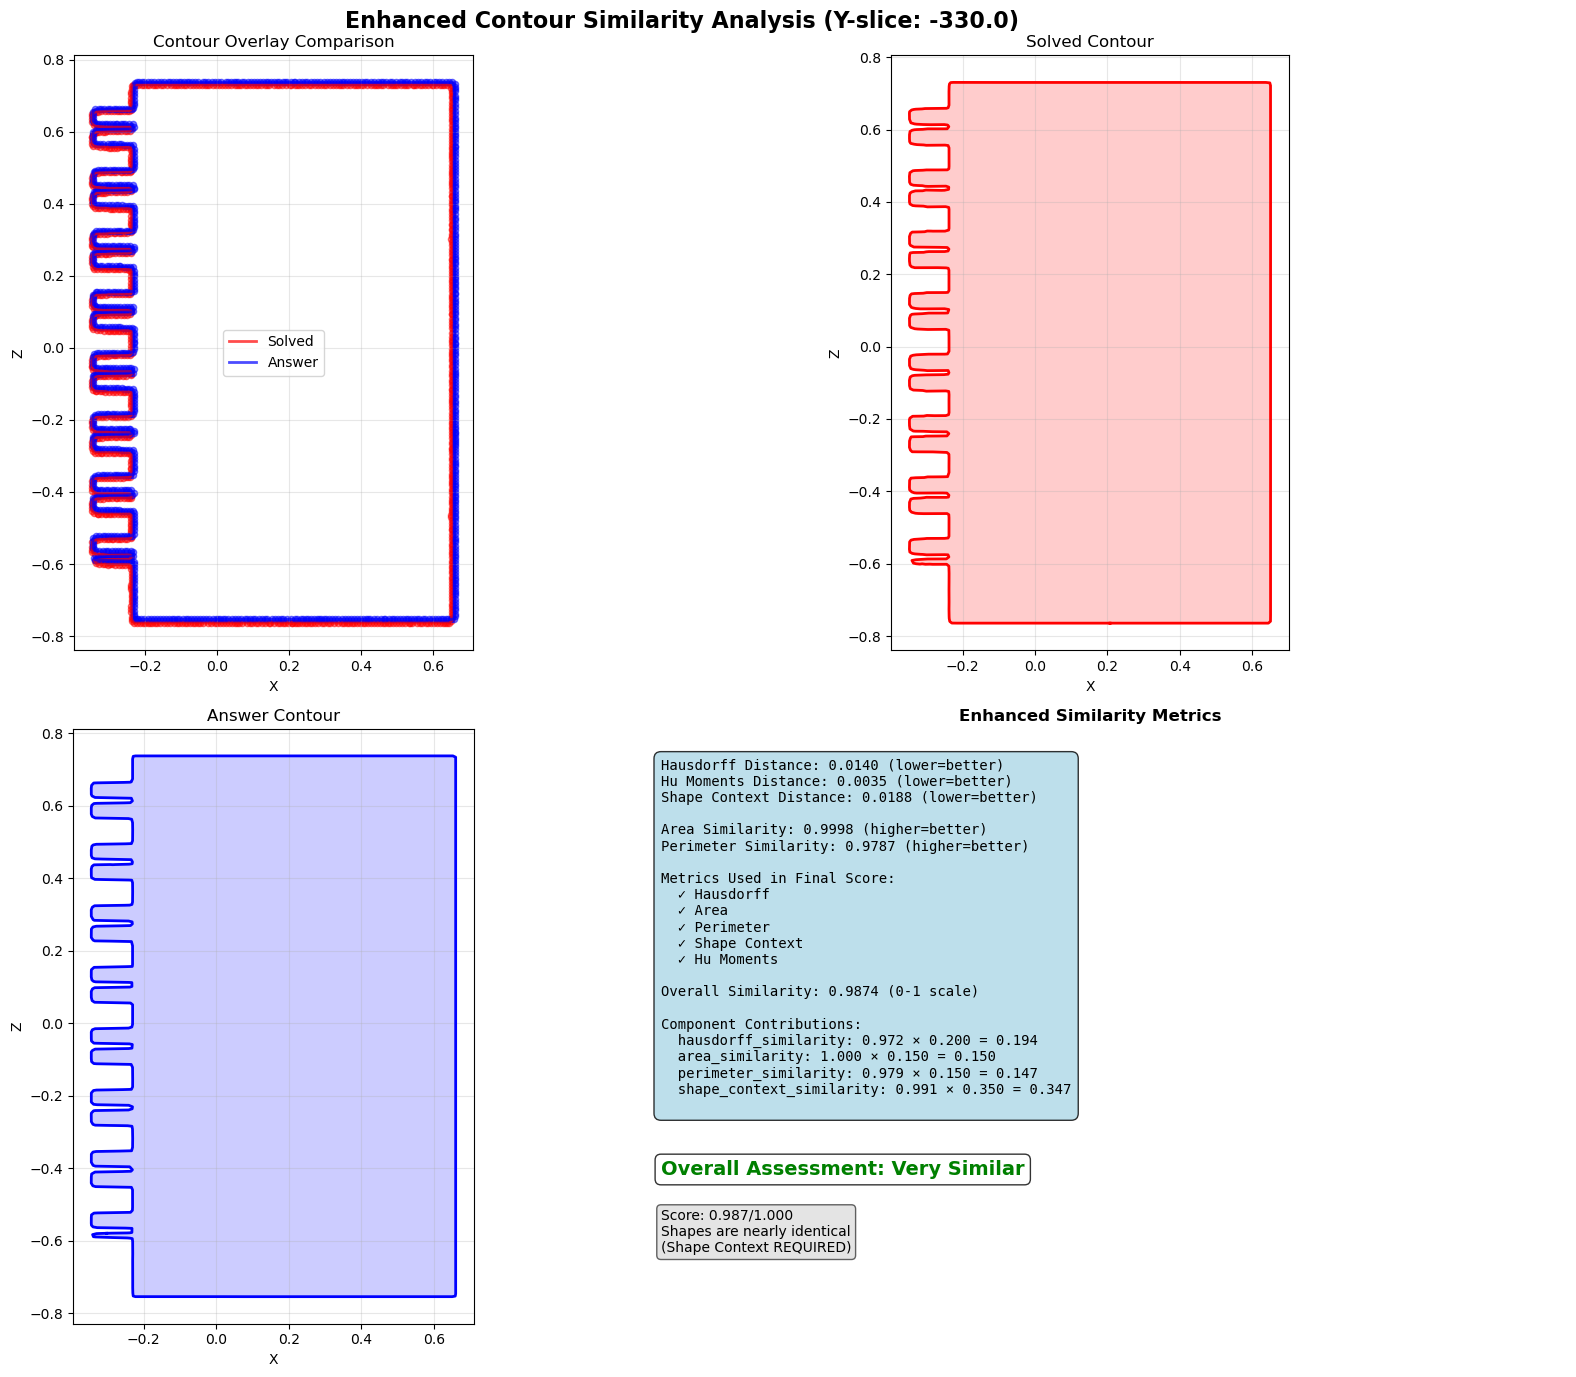

Loading meshes and extracting contours at Y = -248.88888888888889...
Contour 1: 1000 points
Contour 2: 1000 points
Using 5/5 available similarity metrics
✓ Shape Context Distance REQUIRED and included in similarity calculation
✓ Hu Moments Distance also included


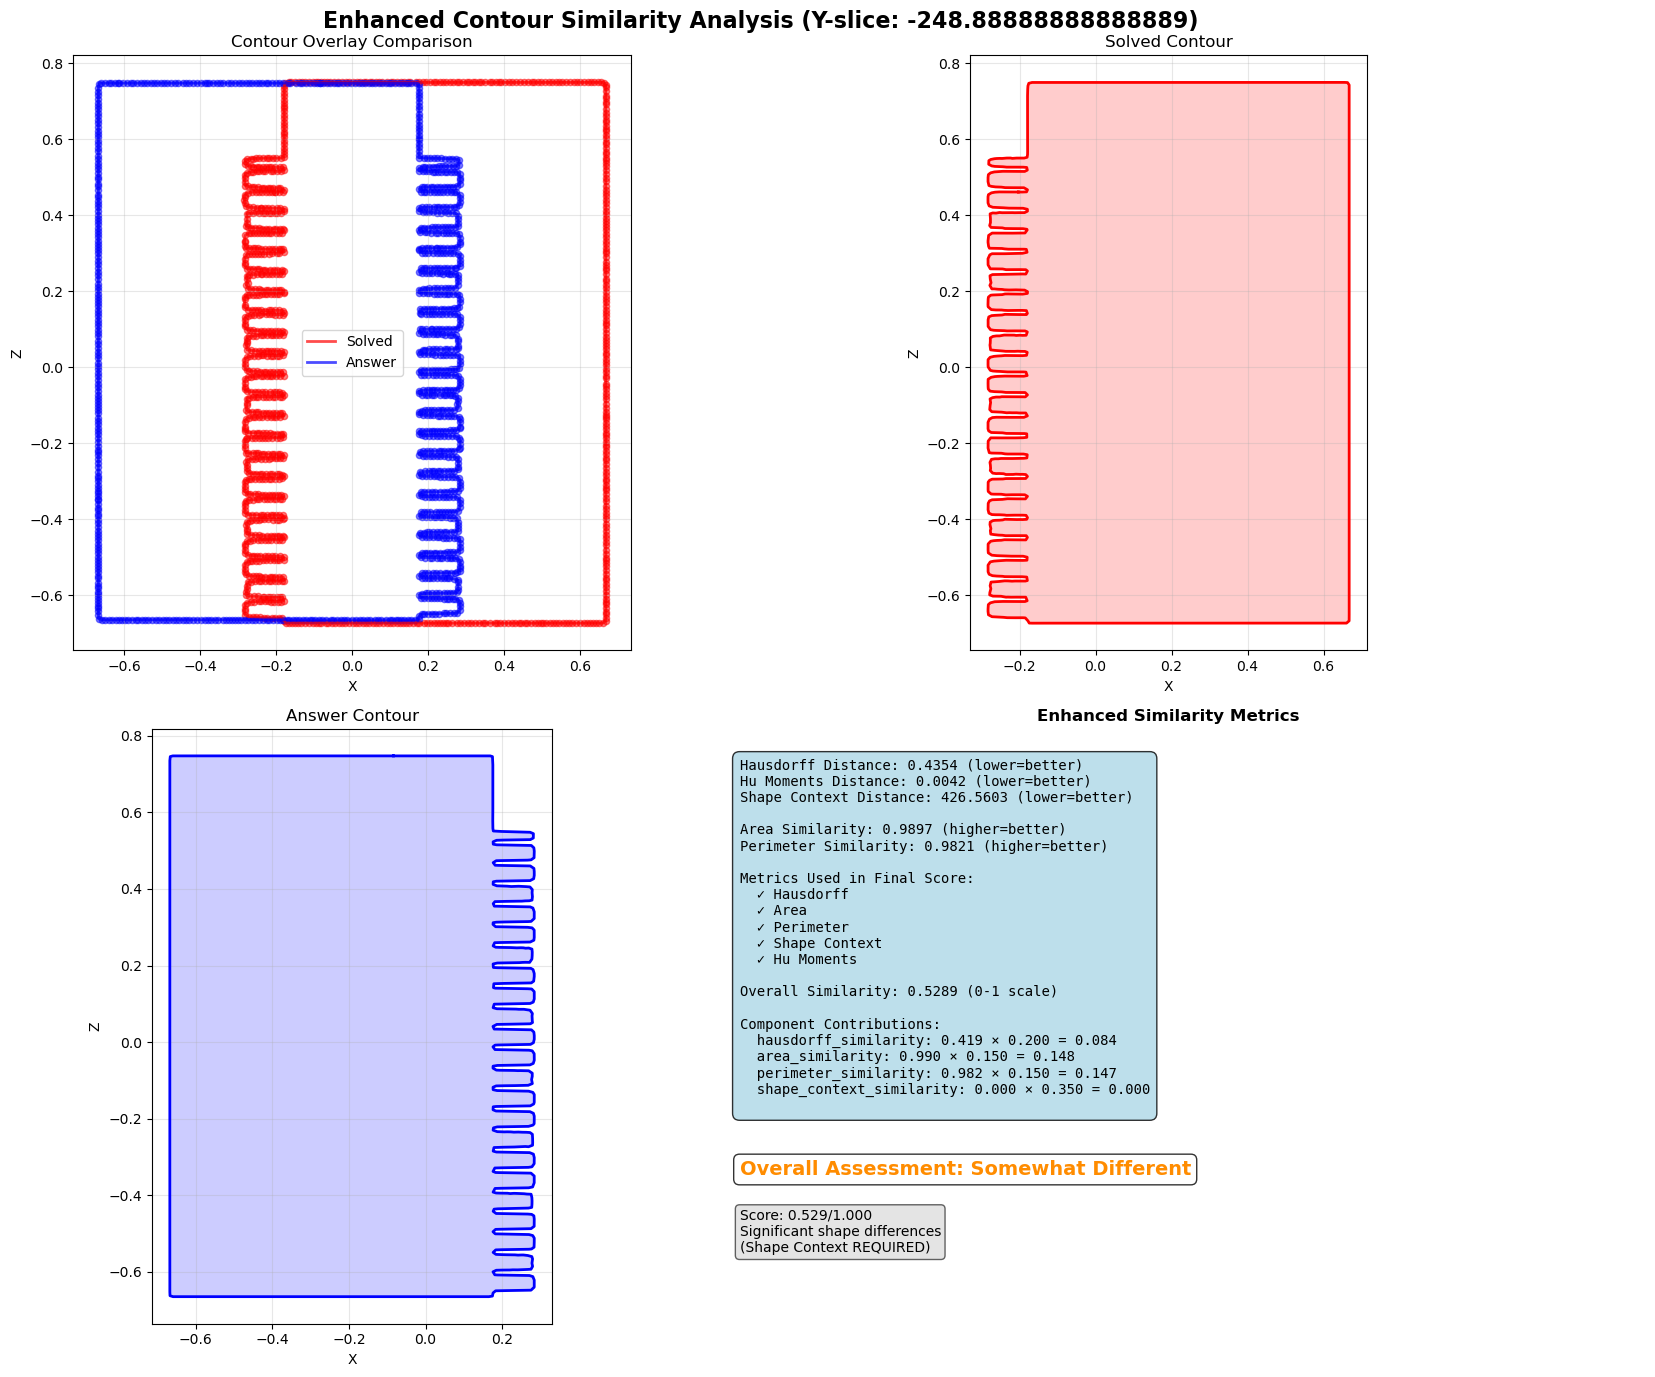

Loading meshes and extracting contours at Y = -167.77777777777777...
Contour 1: 1000 points
Contour 2: 1000 points
Using 5/5 available similarity metrics
✓ Shape Context Distance REQUIRED and included in similarity calculation
✓ Hu Moments Distance also included


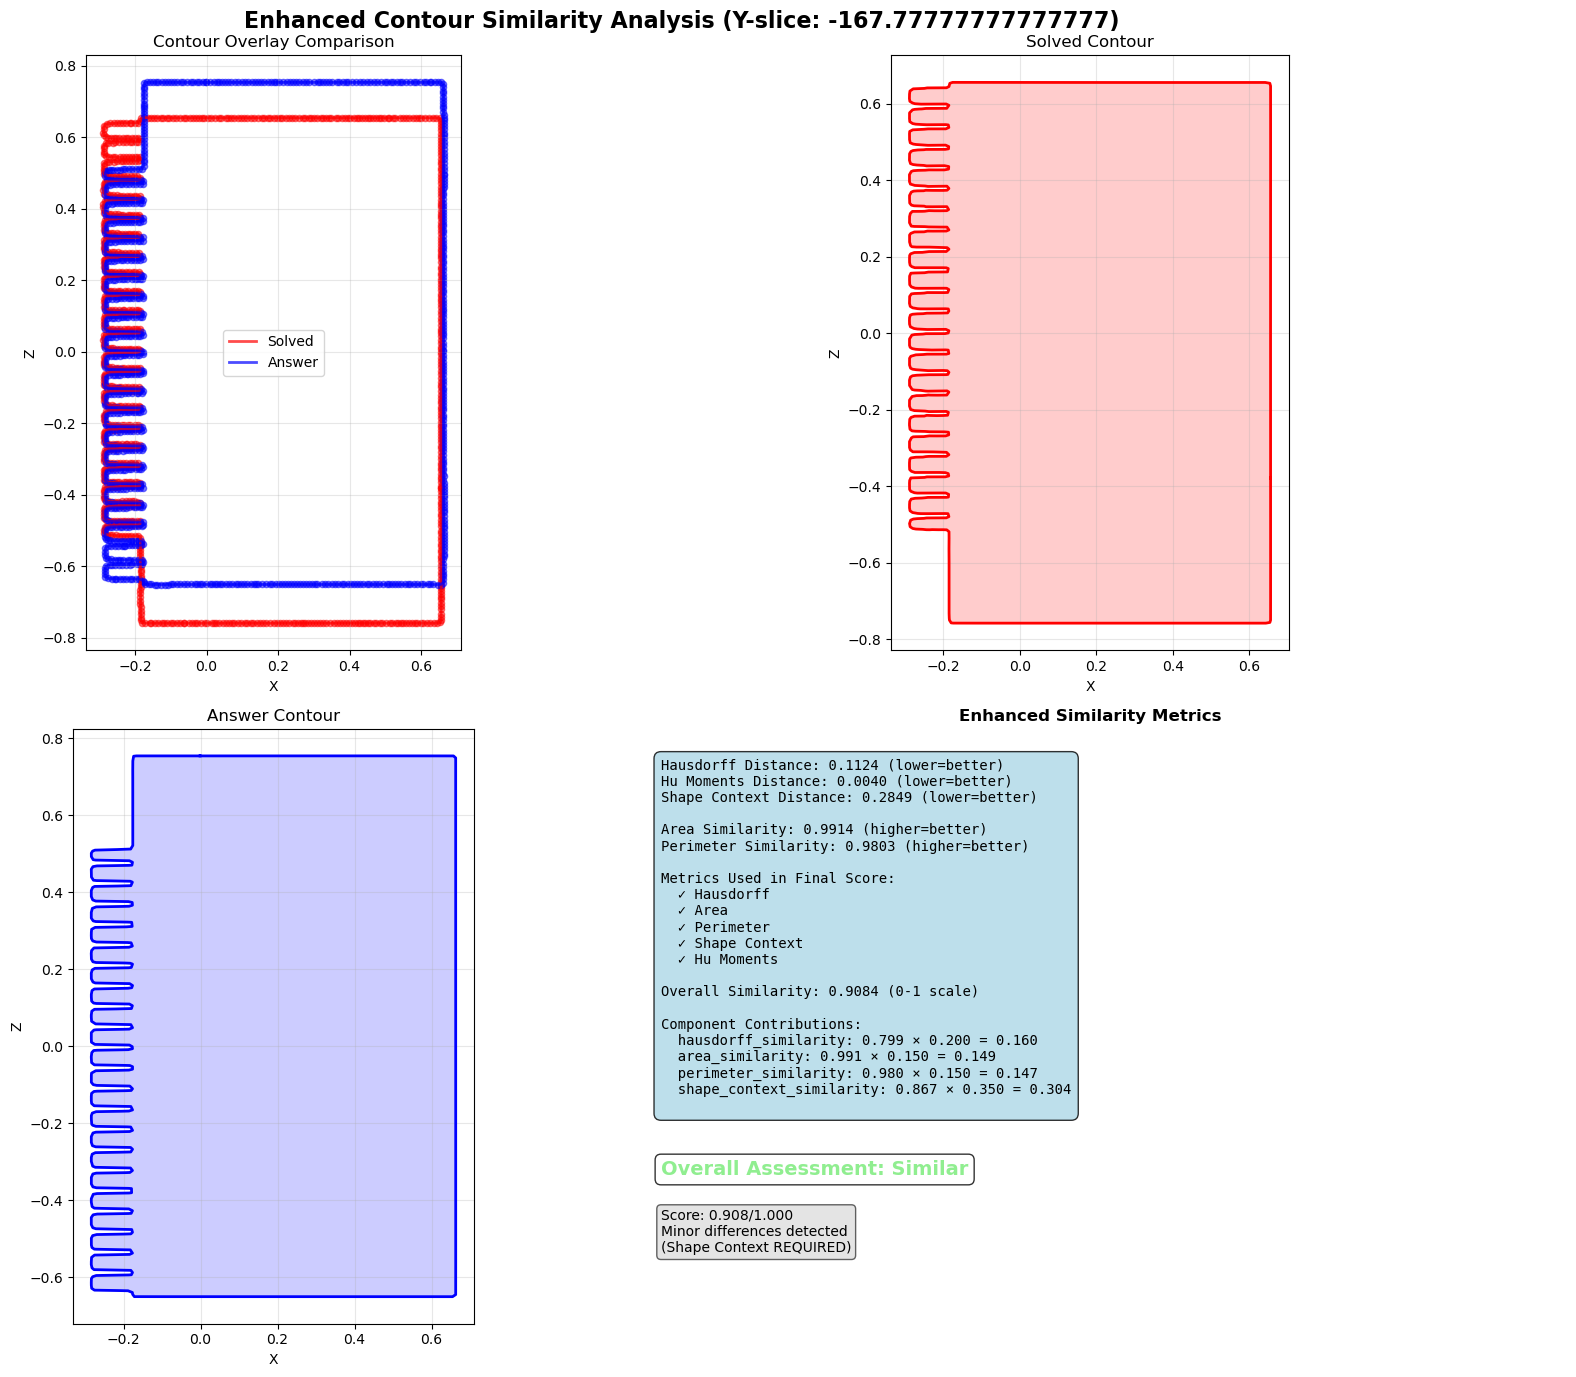

Loading meshes and extracting contours at Y = -86.66666666666666...
Contour 1: 1000 points
Contour 2: 1000 points
Using 5/5 available similarity metrics
✓ Shape Context Distance REQUIRED and included in similarity calculation
✓ Hu Moments Distance also included


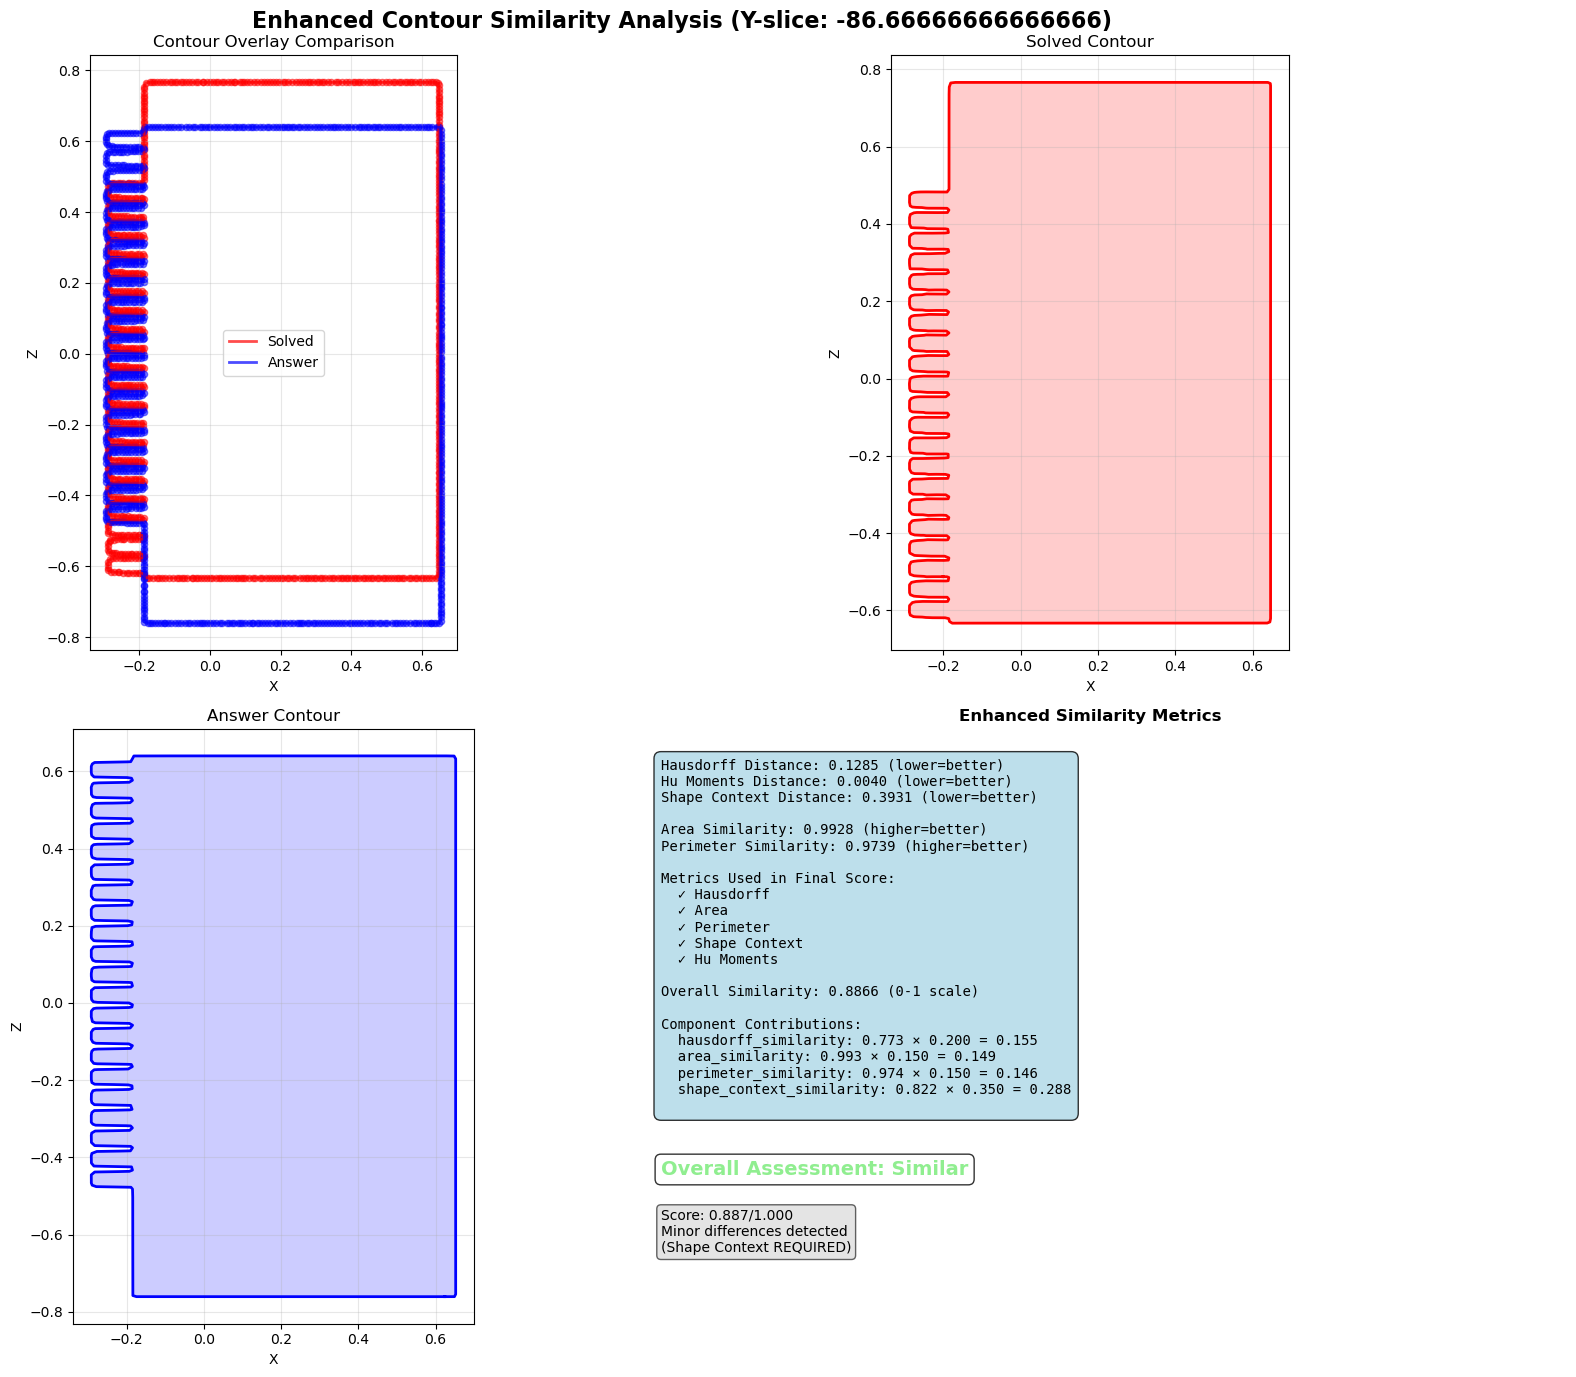

Loading meshes and extracting contours at Y = -5.555555555555543...
Contour 1: 1000 points
Contour 2: 1000 points
Using 5/5 available similarity metrics
✓ Shape Context Distance REQUIRED and included in similarity calculation
✓ Hu Moments Distance also included


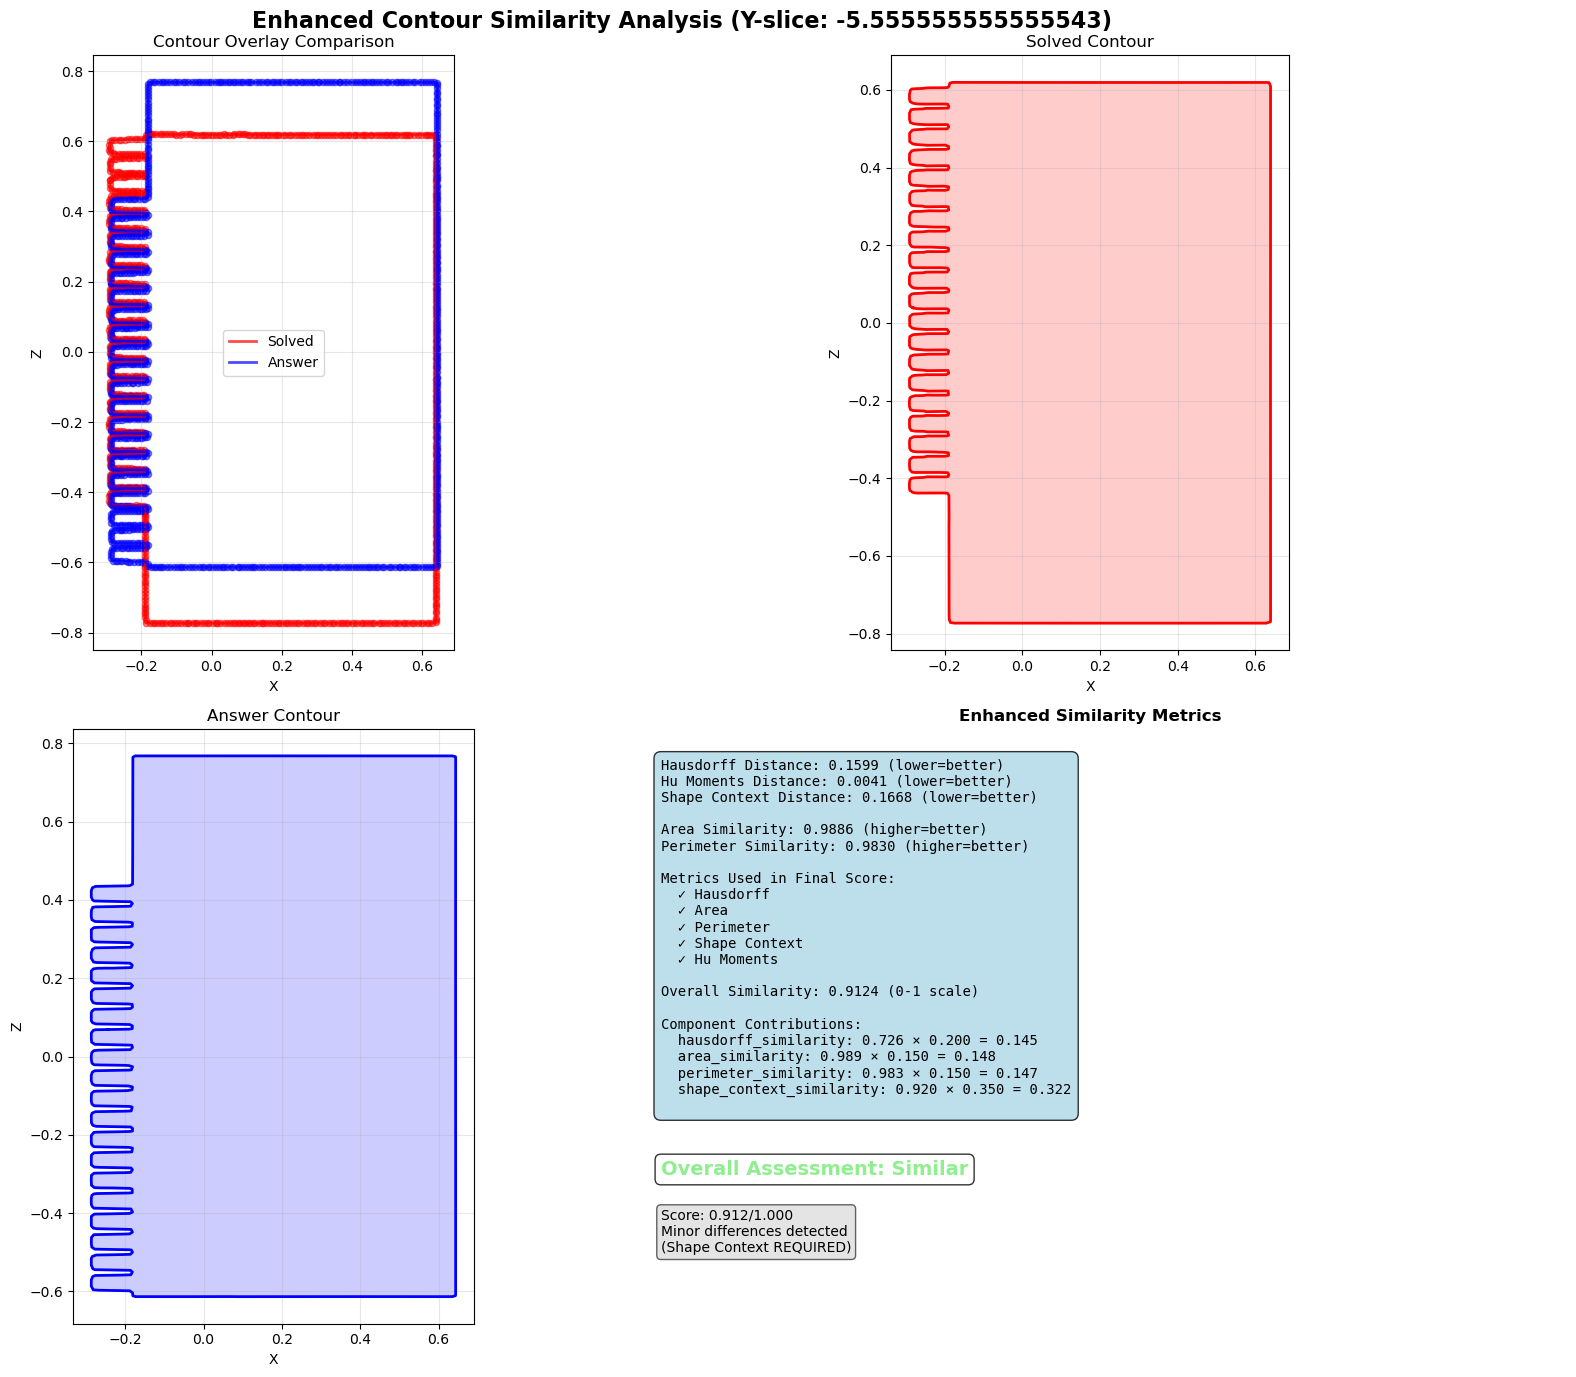

Loading meshes and extracting contours at Y = 75.55555555555554...
Contour 1: 1000 points
Contour 2: 1000 points
Using 5/5 available similarity metrics
✓ Shape Context Distance REQUIRED and included in similarity calculation
✓ Hu Moments Distance also included


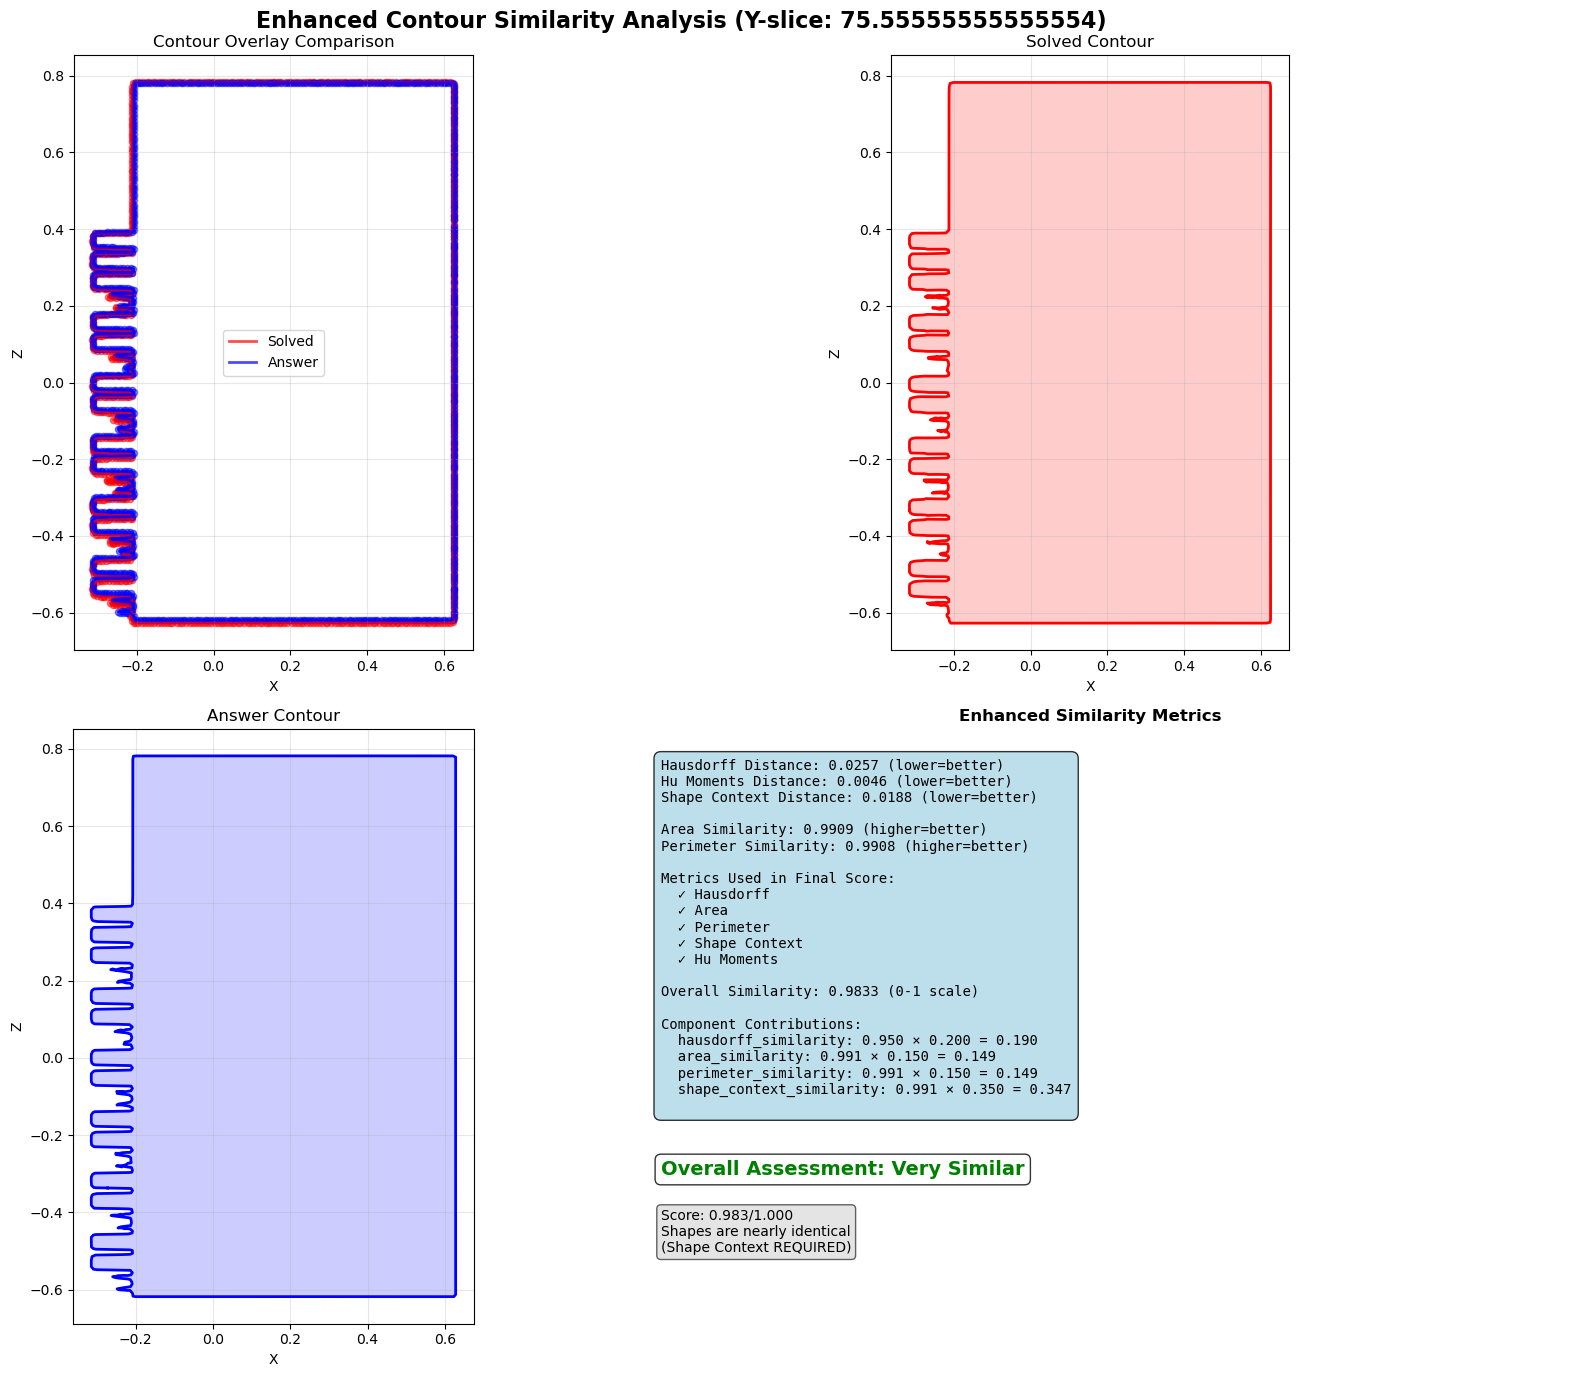

Loading meshes and extracting contours at Y = 156.66666666666669...
Contour 1: 1000 points
Contour 2: 1000 points
Using 5/5 available similarity metrics
✓ Shape Context Distance REQUIRED and included in similarity calculation
✓ Hu Moments Distance also included


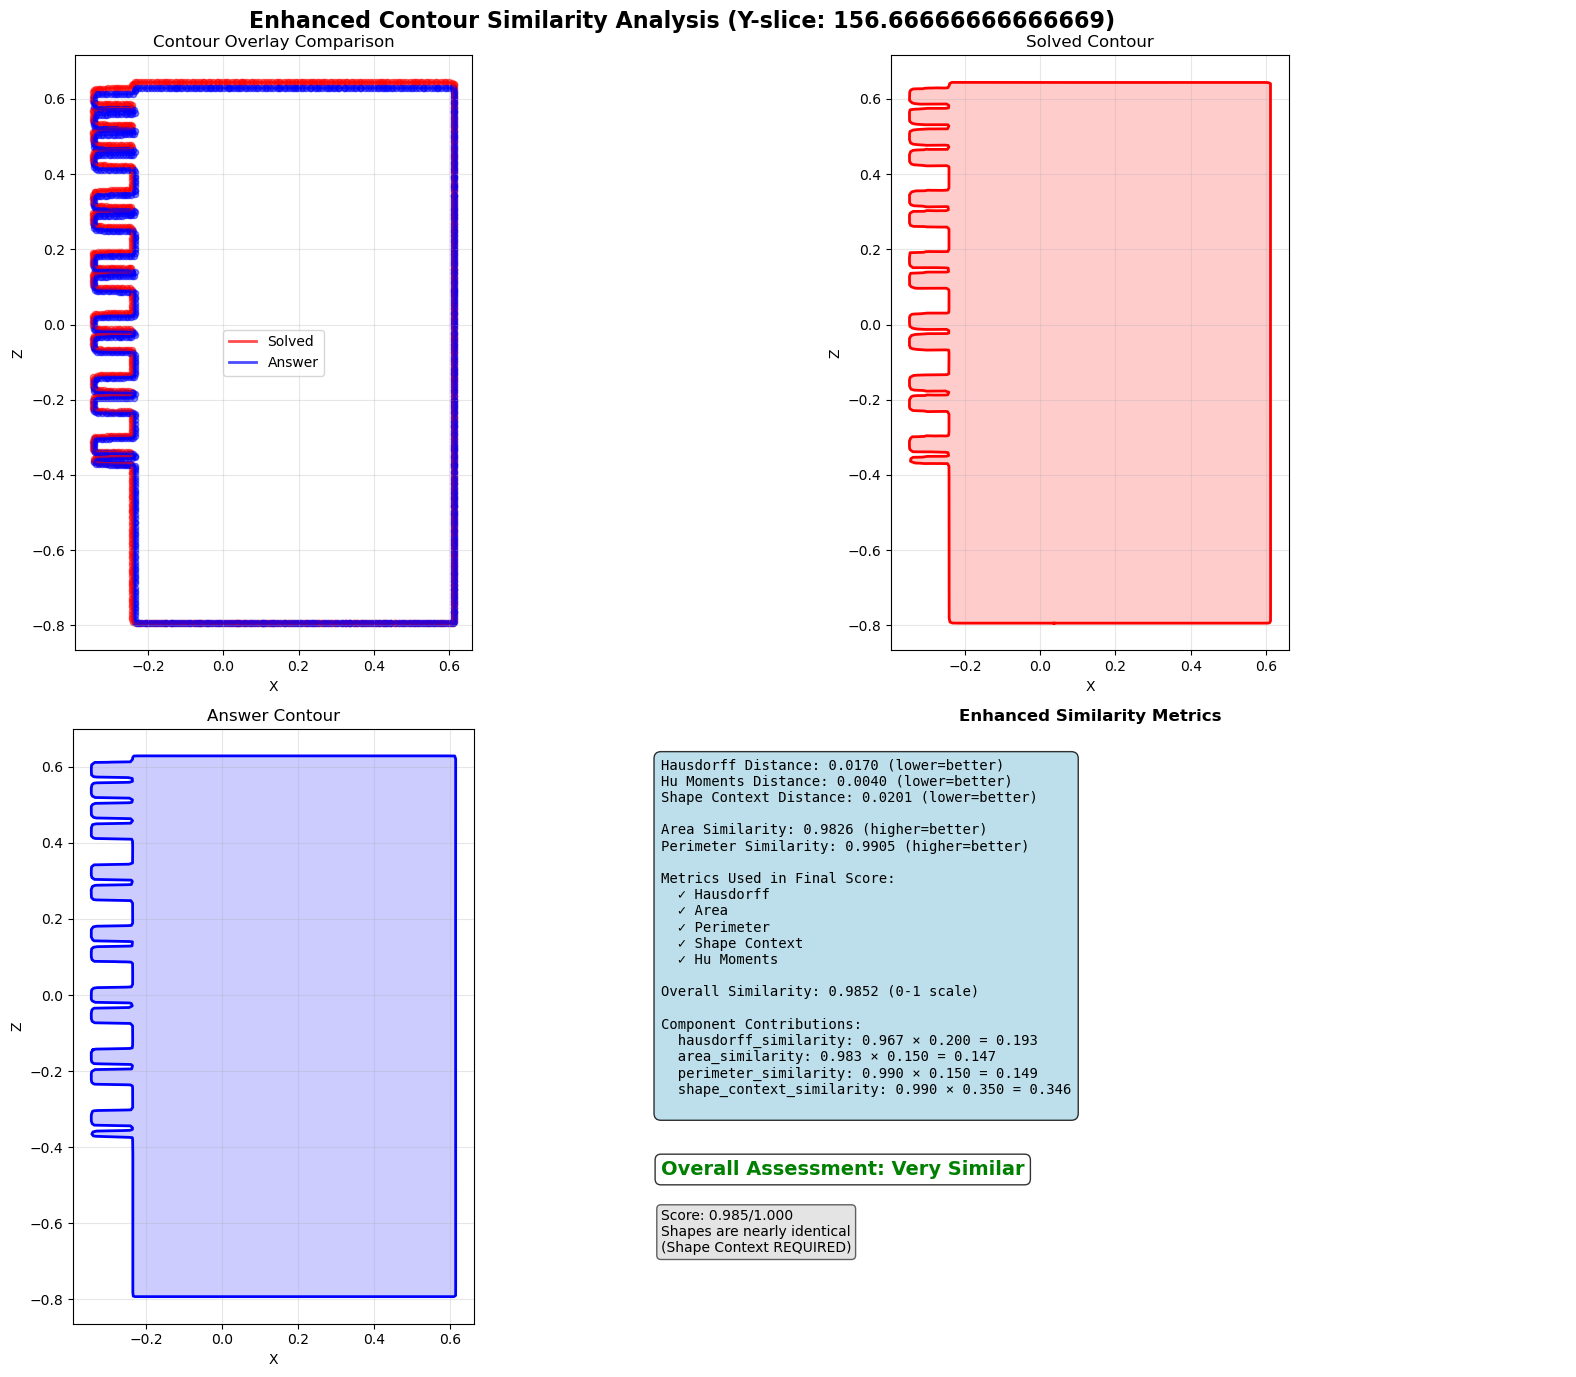

Loading meshes and extracting contours at Y = 237.77777777777783...
Contour 1: 1000 points
Contour 2: 1000 points
Using 5/5 available similarity metrics
✓ Shape Context Distance REQUIRED and included in similarity calculation
✓ Hu Moments Distance also included


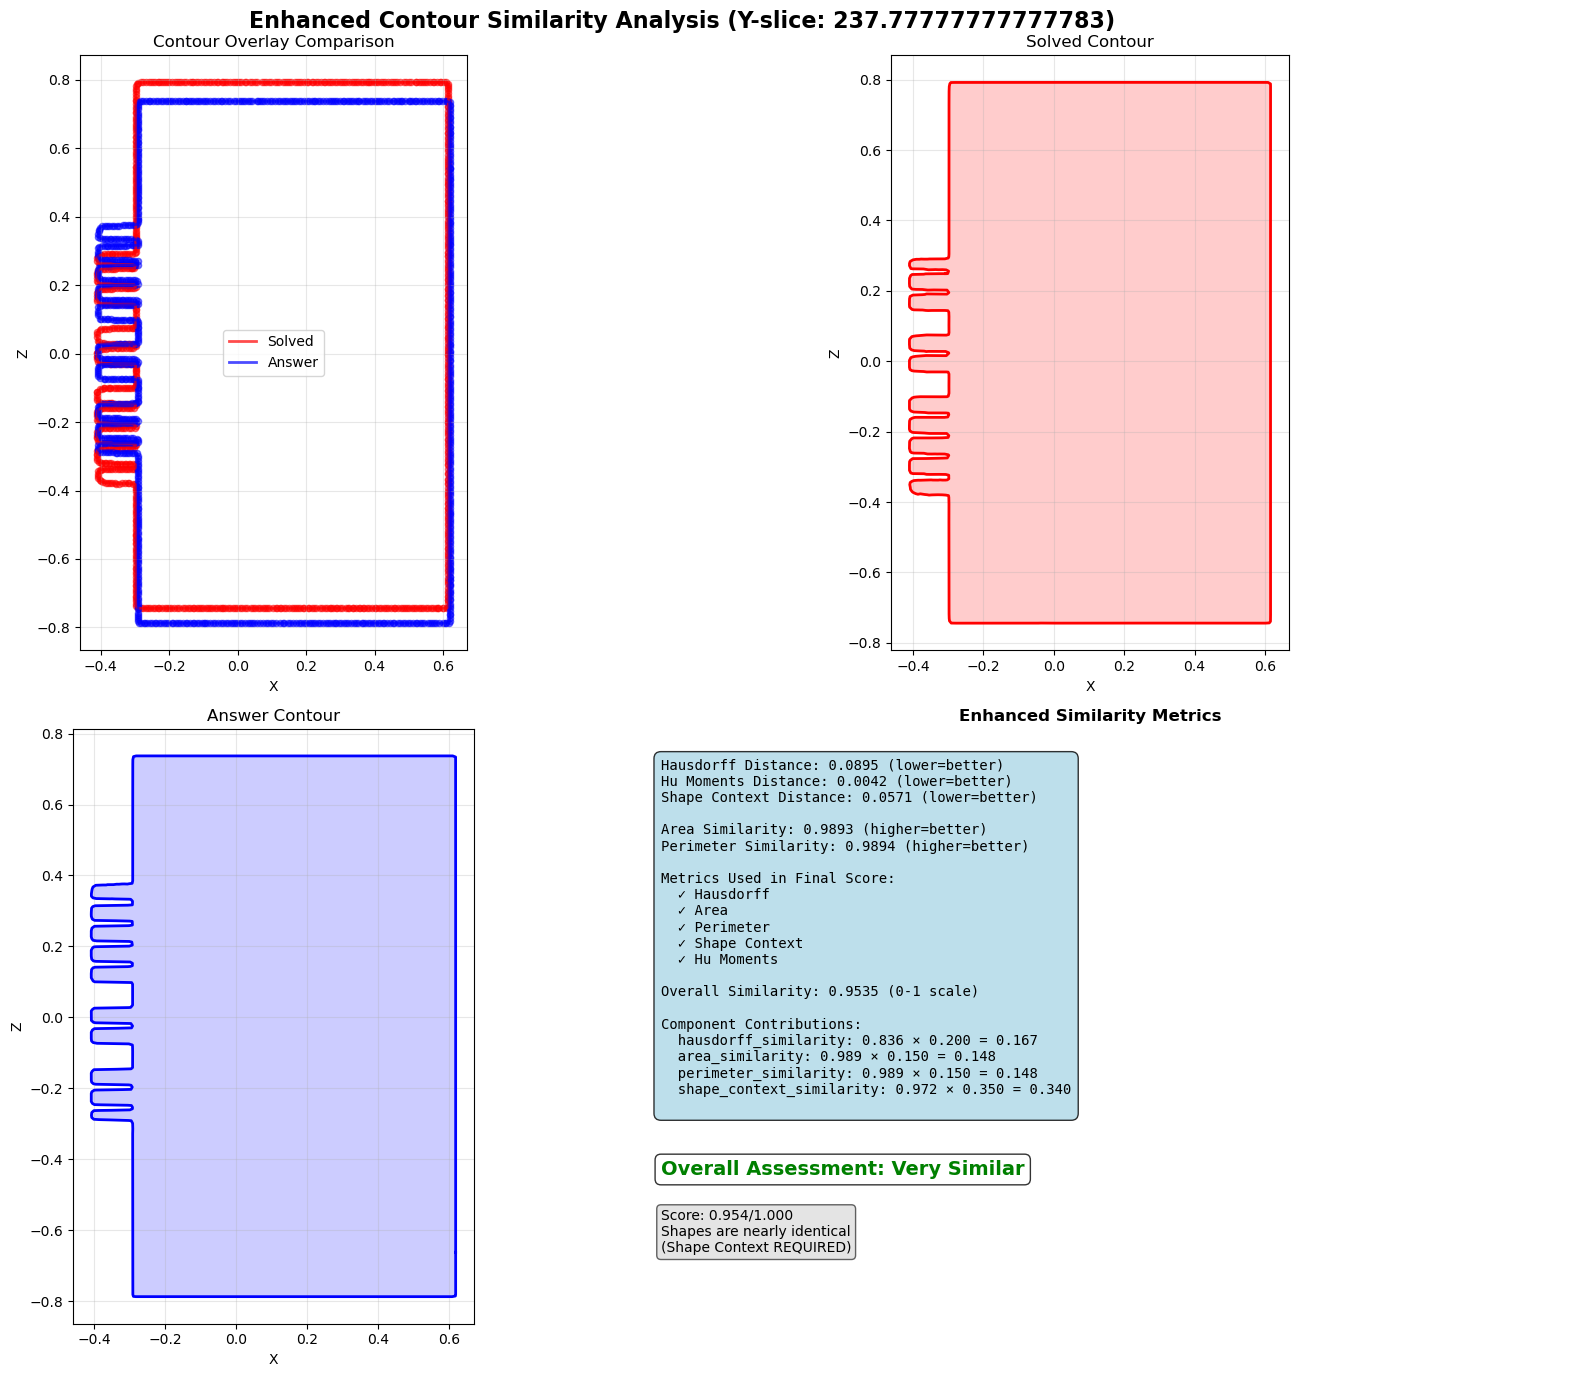

Loading meshes and extracting contours at Y = 318.8888888888889...
Contour 1: 1000 points
Contour 2: 1000 points
Using 5/5 available similarity metrics
✓ Shape Context Distance REQUIRED and included in similarity calculation
✓ Hu Moments Distance also included


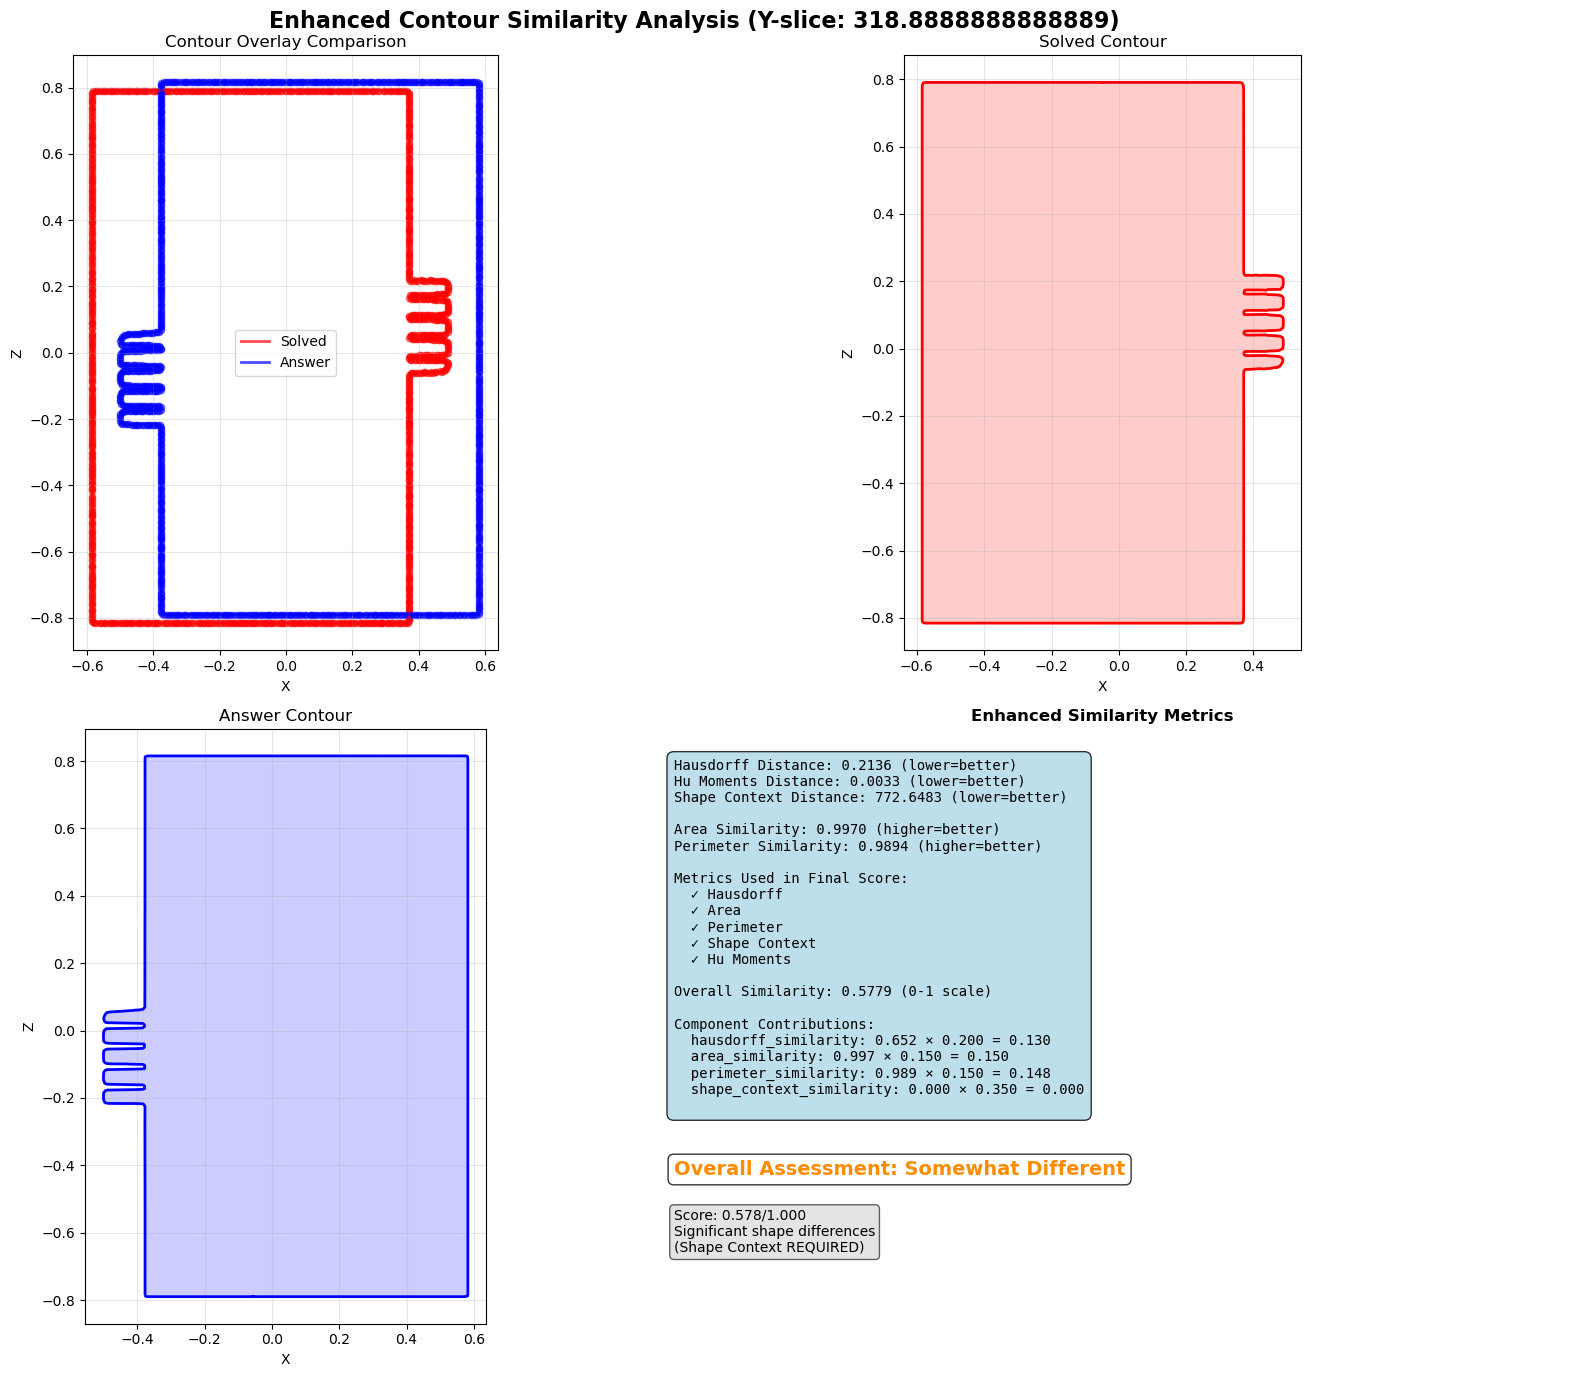

Loading meshes and extracting contours at Y = 400.0...
Contour 1: 1000 points
Contour 2: 1000 points
Using 5/5 available similarity metrics
✓ Shape Context Distance REQUIRED and included in similarity calculation
✓ Hu Moments Distance also included


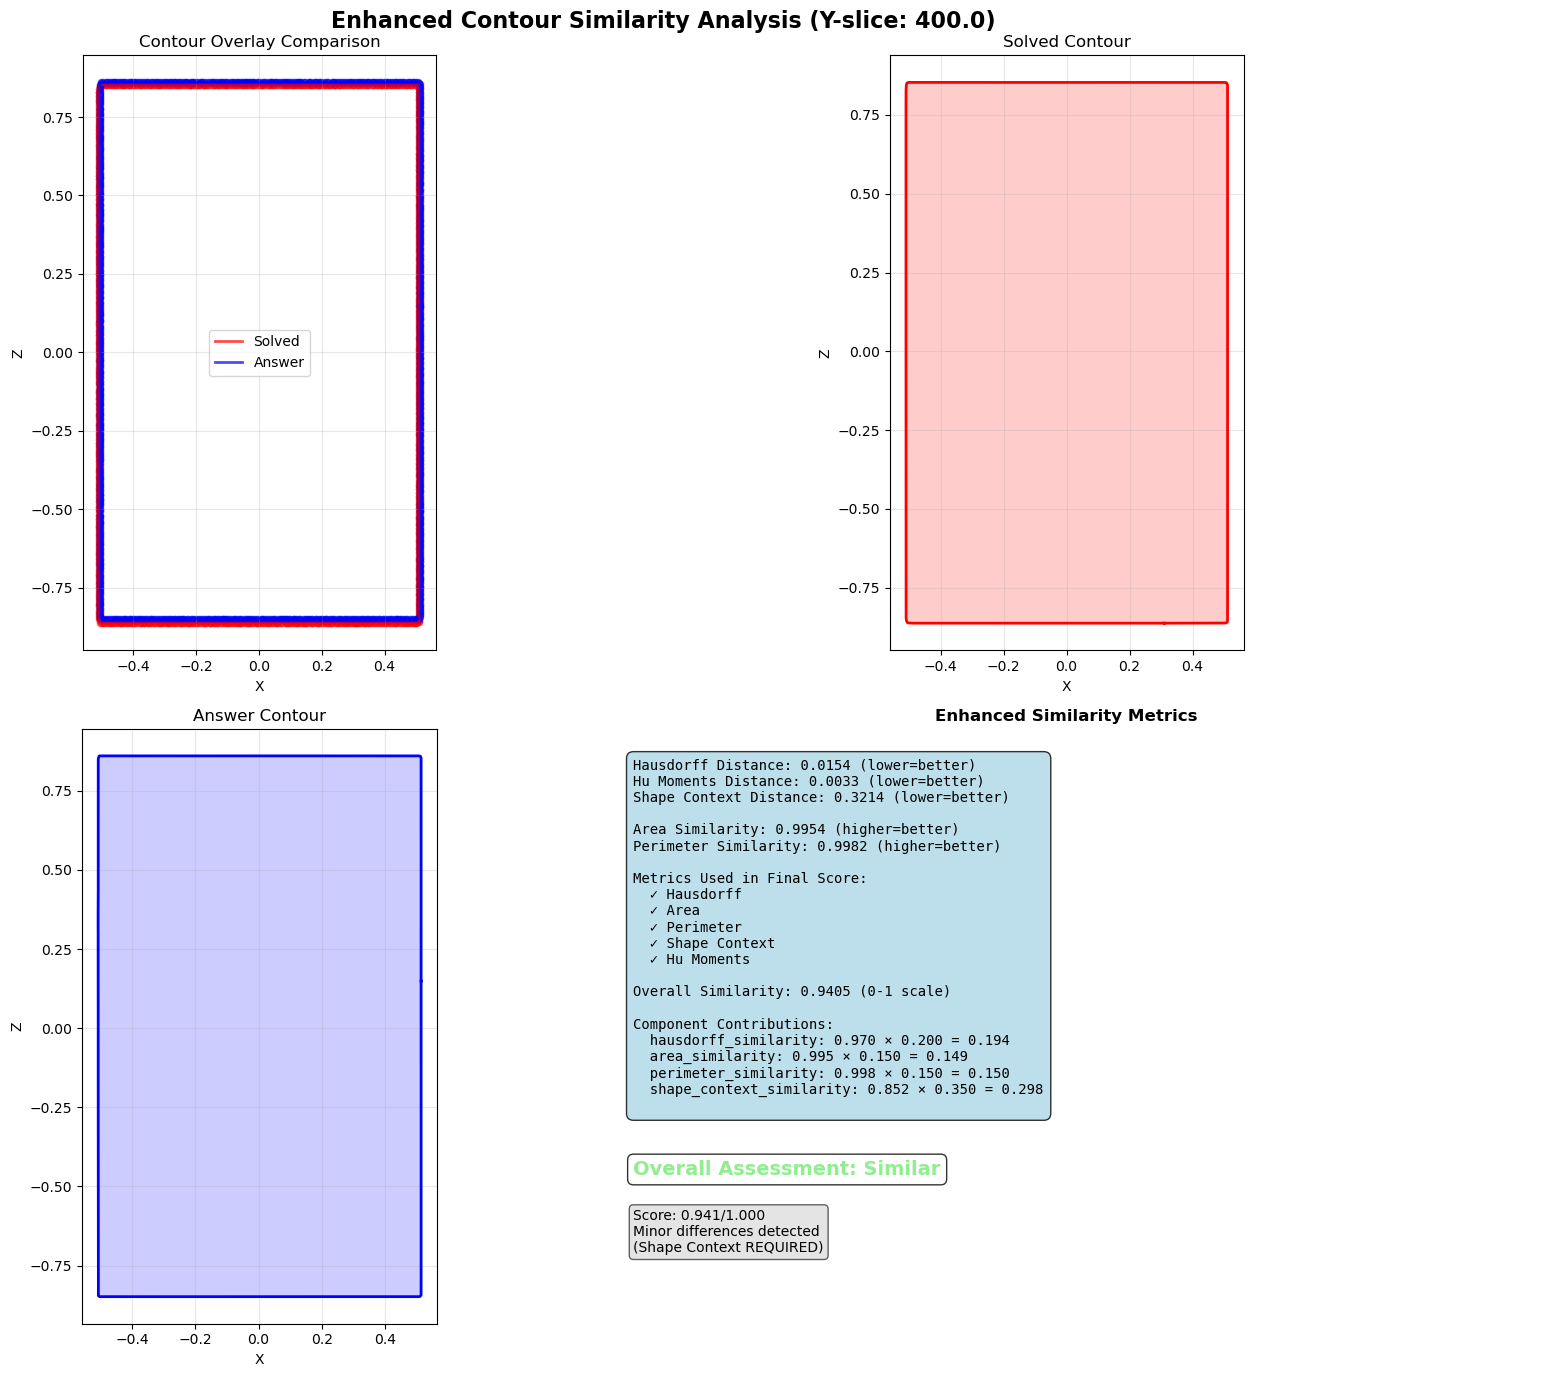

In [49]:
ran = np.linspace(-330, 400, 10)
for i in ran:
	metrics = compare_mesh_contours(
    	file1=file1, 
    	file2=file2, 
    	y_slice_value=i,
    	labels=["Solved", "Answer"],
    	num_points=1000
	)